In [1]:
from google.colab import drive

In [7]:
import numpy as np
import pandas as pd
import re,string,unicodedata
import nltk

In [8]:
from bs4 import BeautifulSoup
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
project_path = '/content/drive/My Drive/Colab Notebooks/'

In [11]:
dfile = project_path + 'Tweets.csv'

In [12]:
tweets_airline = pd.read_csv(dfile)

In [13]:
tweets_airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [14]:
tweets_airline.shape

(14640, 15)

In [15]:
#Tweets description of US Airlines shows there is a high negative reason confidence
tweets_airline.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [16]:
#Using filter function to narrow down selections to text and airline_sentiment columns
extracted_tweets = tweets_airline.filter(['text','airline_sentiment'])

In [17]:
#Checking shape
extracted_tweets.shape

(14640, 2)

In [18]:
#First five rows
extracted_tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [19]:
pd.set_option('display.max_colwidth', None) #Necessary to get a view of the type of HTML strings to filter in RE
extracted_tweets.tail(20) #shows http on record 14625

,text,airline_sentiment
14620,@AmericanAir I wait 2+ hrs for CS to call me back re why flt is cxld/protection &amp; they hang up the minute I answer on 1st ring?,negative
14621,"@AmericanAir I've been on hold for 55 mins about my Cancelled Flighted international flight. Am out of country, so can't leave a call back #. Help?",negative
14622,I just need a place to sleep when I land without accommodations in PLS @AmericanAir!,negative
14623,@AmericanAir Love the new planes for the JFK-LAX run. Maybe one day I will be on one where the amenities all function. #NoCharge #Ever,positive
14624,"@AmericanAir Call me Chairman, or call me Emerald. After what you did today to me, you can call me a former customer.",negative
14625,@AmericanAir Flight 236 was great. Fantastic cabin crew. A+ landing. #thankyou #JFK http://t.co/dRW08djHAI,positive
14626,@AmericanAir Flight 953 NYC-Buenos Aires has been delay since yesterday at 10PM. Is going to take off at 3.30PM now? Give us answers!,negative
14627,"@AmericanAir Flight Cancelled Flightled, can't go home until tomorrow. I could use dinner and a play, @AmericanAir! It's my first time in NYC.",negative
14628,"Thank you. “@AmericanAir: @jlhalldc Customer Relations will review your concerns and contact you back directly, John.”",positive
14629,@AmericanAir How do I change my flight if the phone system keeps telling me that the representatives are busy?,negative


In [20]:
#Removal of HTML tags
for i, row in extracted_tweets.iterrows(): #Counter to iterate through each row of the dataframe
    refined_tweets = re.sub(r"http\S+","",extracted_tweets.at[i,'text'])#Apply whitespace to each occurrence of HTTP(S) on text column
    extracted_tweets.at[i,'text'] = refined_tweets #swap cleaned text to the column text
extracted_tweets.tail(20) #Check to be sure http link on record 14625 is gone

,text,airline_sentiment
14620,@AmericanAir I wait 2+ hrs for CS to call me back re why flt is cxld/protection &amp; they hang up the minute I answer on 1st ring?,negative
14621,"@AmericanAir I've been on hold for 55 mins about my Cancelled Flighted international flight. Am out of country, so can't leave a call back #. Help?",negative
14622,I just need a place to sleep when I land without accommodations in PLS @AmericanAir!,negative
14623,@AmericanAir Love the new planes for the JFK-LAX run. Maybe one day I will be on one where the amenities all function. #NoCharge #Ever,positive
14624,"@AmericanAir Call me Chairman, or call me Emerald. After what you did today to me, you can call me a former customer.",negative
14625,@AmericanAir Flight 236 was great. Fantastic cabin crew. A+ landing. #thankyou #JFK,positive
14626,@AmericanAir Flight 953 NYC-Buenos Aires has been delay since yesterday at 10PM. Is going to take off at 3.30PM now? Give us answers!,negative
14627,"@AmericanAir Flight Cancelled Flightled, can't go home until tomorrow. I could use dinner and a play, @AmericanAir! It's my first time in NYC.",negative
14628,"Thank you. “@AmericanAir: @jlhalldc Customer Relations will review your concerns and contact you back directly, John.”",positive
14629,@AmericanAir How do I change my flight if the phone system keeps telling me that the representatives are busy?,negative


In [21]:
extracted_tweets.head(20)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there.",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


In [25]:
!pip install contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     |████████████████████████████████| 317kB 7.6MB/s 
     |████████████████████████████████| 245kB 12.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81706 sha256=0d0c7109ab62c89153b25c500832346cc7fcfaf3130a6bb737061b61edb57881
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [26]:
#Text cleaning to replace contractions as visible in the text column rows
import contractions
def replace_contractions(text):
    return contractions.fix(text)

#Loop over the rows of the text columns to implement defined contraction method
for i,row in extracted_tweets.iterrows():
    temp_text = extracted_tweets.at[i,'text']
    refined_text = replace_contractions(temp_text)
    extracted_tweets.at[i,'text'] = refined_text
extracted_tweets.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials to the experience... tacky.,positive
2,@VirginAmerica I did not today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it is a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there.",neutral
8,"@virginamerica Well, I did not…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me.",positive


In [27]:
#Tokenization of the text
for i,row in extracted_tweets.iterrows():
    temp_text = extracted_tweets.at[i,'text']
    refined_text = nltk.word_tokenize(temp_text)
    extracted_tweets.at[i,'text'] = refined_text
extracted_tweets.head(10)

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]",neutral
3,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, amp, ;, they, have, little, recourse]",negative
4,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative
5,"[@, VirginAmerica, seriously, would, pay, $, 30, a, flight, for, seats, that, did, not, have, this, playing, ., it, is, really, the, only, bad, thing, about, flying, VA]",negative
6,"[@, VirginAmerica, yes, ,, nearly, every, time, I, fly, VX, this, “, ear, worm, ”, will, not, go, away, :, )]",positive
7,"[@, VirginAmerica, Really, missed, a, prime, opportunity, for, Men, Without, Hats, parody, ,, there, .]",neutral
8,"[@, virginamerica, Well, ,, I, did, not…but, NOW, I, DO, !, :, -D]",positive
9,"[@, VirginAmerica, it, was, amazing, ,, and, arrived, an, hour, early, ., you, are, too, good, to, me, .]",positive


In [28]:
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [29]:
#Functions for removing Special Characters, Numbers, Punctuations, lowercase
def remove_non_ascii(words): #Function for non english characters
    new_words = []
    for word in words:
        temp_new_words = unicodedata.normalize('NFKD',word).encode('ascii','ignore').decode('utf-8','ignore')
        new_words.append(temp_new_words)
    return new_words
def to_lowercase(words): #Function for lower case
    new_words1 = []
    for word in words:
        temp_new_words1 = word.lower()
        new_words1.append(temp_new_words1)
    return new_words1
def remove_punctuation(words):
    new_words2 = []
    for word in words:
        temp_new_words2 = re.sub(r'[^\w\s]','',word)
        if temp_new_words2 != "":
            new_words2.append(temp_new_words2)
    return new_words2
def remove_stopwords(words):
    new_words3 = []
    for word in words:
        if word not in stopwords:
            new_words3.append(word)
    return new_words3

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word,pos='v')
        lemmas.append(lemma)
    return lemmas

In [30]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return ' '.join(words) #To convert list back into text strings in the dataframe

In [31]:
#Implement normalize function for every row of the text column and display top five rows
for i,row in extracted_tweets.iterrows():
    words = extracted_tweets.at[i,'text']
    words = normalize(words)
    extracted_tweets.at[i,'text'] = words
extracted_tweets.head()

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience tacky,positive
2,virginamerica today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guests face amp little recourse,negative
4,virginamerica really big bad thing,negative


In [32]:
#Using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(extracted_tweets['text'])
data_features = data_features.toarray()

In [33]:
data_features.shape

(14640, 1000)

In [34]:
#One hot encoding for airline sentiment using label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
extracted_tweets['airline_sentiment'] = le.fit_transform(extracted_tweets['airline_sentiment'].values)

In [35]:
#Ensure labels are in integer data type
labels = extracted_tweets['airline_sentiment']
labels = labels.astype('int')

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data_features,labels,test_size=0.3,random_state=1)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest = RandomForestClassifier(n_estimators=10,n_jobs=4)
forest = forest.fit(X_train,Y_train)
print(forest)
print(np.mean(cross_val_score(forest,data_features,labels,cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6997267759562842


In [38]:
result = forest.predict(X_test) #Predict scores

[[2385  255  101]
 [ 403  445   88]
 [ 172  133  410]]


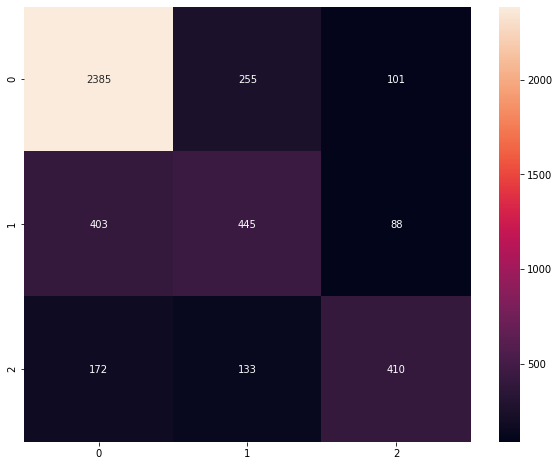

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(Y_test,result)#Compare test and the results
print(confusion_mat)
dframe_cm = pd.DataFrame(confusion_mat,index = [i for i in "012"],columns= [i for i in "012"])
plt.figure(figsize=(10,8))
sns.heatmap(dframe_cm,annot=True,fmt='g')

In [40]:
#Using TFid Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(extracted_tweets['text'])
data_features = data_features.toarray()
data_features.shape

(14640, 1000)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest = RandomForestClassifier(n_estimators=10,n_jobs=4)
forest = forest.fit(X_train,Y_train)
print(forest)
print(np.mean(cross_val_score(forest,data_features,labels,cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7012978142076502


In [42]:
result = forest.predict(X_test) #Predict result

[[2381  255  105]
 [ 392  446   98]
 [ 192  127  396]]


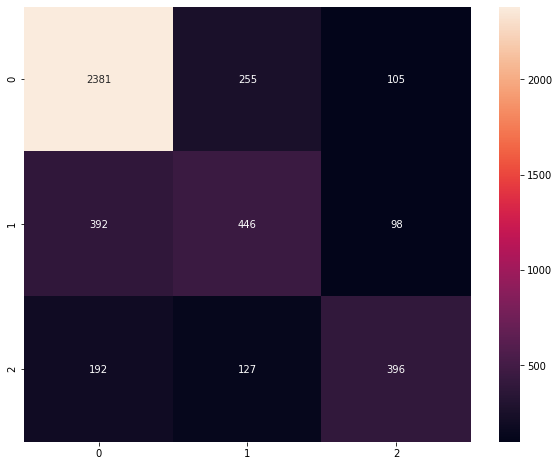

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(Y_test,result)#Compare test and the results
print(confusion_mat)
dframe_cm = pd.DataFrame(confusion_mat,index = [i for i in "012"],columns= [i for i in "012"])
plt.figure(figsize=(10,8))
sns.heatmap(dframe_cm,annot=True,fmt='g')

#Summary

> **Preprocessing logic:**


*   Display width was increased to have a full view of some data samples
*   HTML Parsing was done using regular expression and iterating through the rows of the text column
*   Contraction and Tokenization was subsequently done
*   Special Characters, Conversion to lower case, Removal of punctuation and stop words, as well as lemmatization were implemented


> **Vectorization:**
*   Count Vectorizer and Tfidf Vectorizer were implemented and results compared to determine the most efficient model
*   Confusion Matrix was used to display the performance of the model on airline sentiments using both count & Tfidf vectorizer


> **Performance:**


*   The model perfomed slightly better with Tfidf Vectorizer as compared with Count vectorizer
*   Tfidf Vectorizer performance increased slightly with an increase in the max_features, whereas Count vectorizer decreases with an increase in the max_features


    
    